In [1]:
import numpy as np
import pandas as pd

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [3]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [5]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [6]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [7]:
from sklearn.model_selection import train_test_split, KFold

In [8]:
n_splits = 10


In [9]:
from common import compute_rmse

In [10]:
def learn_HAT_random_normal_check(case, E_np_masked, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
          A_known=None, T_known=None, random_seed=0, random_mul_constant=1,
              random_add_constant=0):
    np.random.seed(random_seed)
    if cost_function == 'abs':
        cost = cost_abs
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 1, 2])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)*random_mul_constant+random_add_constant

    A = np.random.rand(*A_dim)*random_mul_constant+random_add_constant
    T = np.random.rand(*T_dim)*random_mul_constant+random_add_constant
#     print (T)

    Hs =[H.copy()]
    As= [A.copy()]
    Ts = [T.copy()]
    costs = [cost_abs(H, A, T, E_np_masked, 2)]
    HATs =[multiply_case(H, A, T, 2)]
    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, E_np_masked, case)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t
#         print ("del_t: ", del_t)
        # Projection to known values
        if H_known is not None:
            H = set_known(H, H_known)
        if A_known is not None:
            A = set_known(A, A_known)
        if T_known is not None:
            T = set_known(T, T_known)
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
#         print (T)
        As.append(A.copy())
        Ts.append(T.copy())
        Hs.append(H.copy())
#         print (Ts)
        costs.append(cost_abs(H, A, T, E_np_masked, 2))
        HATs.append(multiply_case(H, A, T, 2))
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, E_np_masked, case))
    return H, A, T, Hs, As, Ts, HATs, costs




In [45]:
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_random_normal_check(case, au_tensor, a, 3, num_iter=10000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))


In [65]:
out = {}
for scale in [1]:
    out[scale] = {}
    for random_seed in range(1):
        
        out[scale][random_seed] = {}
        for c in [1]:
            out[scale][random_seed][c] = {}
            print (scale, random_seed, c)
            tensor_copy = tensor.copy()
            ################# PLEASE SEE THE LINE BELOW- CHANGED FROM learn_HAT to learn_HAT_random_normal #######
            H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_random_normal_check(case, tensor_copy, a, 3, num_iter=20000, lr=0.1, dis=False, cost_function=cost, A_known = A, T_known=np.ones(12).reshape(-1, 1))
            out[scale][random_seed][c] = {'Hs':Hs, 'As':As, 'Ts':Ts, 'HATs':HATs, 'costs':costs}

1 0 1


In [66]:
from plot_functions import *

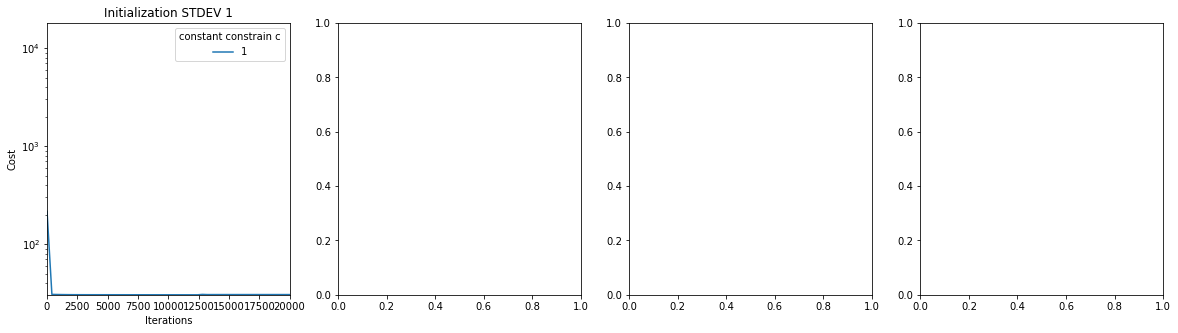

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
ax = axes.flatten()
random_seed=0
c=1
scale=20
count=0
# fig, ax  =plt.subplots()
for scale in [1]:
    for c in [1]:
        tdf = pd.DataFrame({c:out[scale][random_seed][c]['costs'][::step]}, index=range(len(out[scale][0][c]['costs']))[::step])
        tdf.plot(logy=True, ax=ax[count])
        
    ax[count].set_ylim([0, 18000])
    ax[count].legend(title='constant constrain c')

    ax[count].set_xlabel("Iterations")
    ax[count].set_ylabel("Cost")
    ax[count].set_title("Initialization STDEV " + str(scale))

#         plt.xlim((-10, 12300))
#         plt.ylim((0, 18000))
#         plt.legend(title='Initialisation STDEV')
#         format_axes(ax[count])
#         plt.xlabel("Iterations")
#         plt.ylabel("Cost")
    count+=1

[0,
 400,
 800,
 1200,
 1600,
 2000,
 2400,
 2800,
 3200,
 3600,
 4000,
 4400,
 4800,
 5200,
 5600,
 6000,
 6400,
 6800,
 7200,
 7600,
 8000,
 8400,
 8800,
 9200,
 9600,
 10000,
 10400,
 10800,
 11200,
 11600,
 12000,
 12400,
 12800,
 13200,
 13600,
 14000,
 14400,
 14800,
 15200,
 15600,
 16000,
 16400,
 16800,
 17200,
 17600,
 18000,
 18400,
 18800,
 19200,
 19600,
 20000]

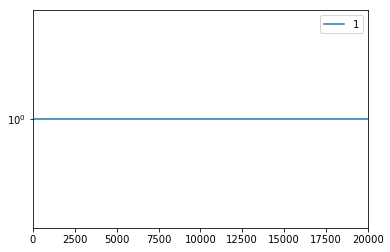

In [68]:
fig, ax  =plt.subplots()
tdf = pd.DataFrame({c:out[scale][random_seed][c]['Ts'][1][1][::step]}, index=range(len(out[scale][0][c]['costs']))[::step])
tdf.plot(logy=True, ax=ax)
range(len(out[scale][0][c]['costs']))[::step]

In [71]:
out[scale][random_seed][1]['Ts'][15000]

array([[ 1.        ,  3.07599995,  0.        ],
       [ 1.        ,  2.64245809,  0.        ],
       [ 1.        ,  2.95272751,  0.        ],
       [ 1.        ,  2.93524232,  0.22876026],
       [ 1.        ,  2.26441892,  1.7031928 ],
       [ 1.        ,  2.54889043,  1.13736994],
       [ 1.        ,  1.75695503,  2.89392693],
       [ 1.        ,  1.58357219,  3.29343425],
       [ 1.        ,  1.82513654,  3.54180548],
       [ 1.        ,  2.81594708,  1.33822482],
       [ 1.        ,  3.21874181,  0.        ],
       [ 1.        ,  3.78363729,  0.        ]])

In [97]:
Tfactors = {}
for scale in [1]:
    Tfactors[scale] = {}
    for random_seed in range(1):
        Tfactors[scale][random_seed] = {}
        for c in [1]:
            Tfactors[scale][random_seed][c] = {}
            for j in range(12):
                Tfactors[scale][random_seed][c][j] = []
                
for scale in [1]:
    for random_seed in range(1):
        for c in [1]:
            for i in range(0, 20200, 400):
                for j in range(0, 12):
                    Tfactors[scale][random_seed][c][j].append(out[scale][random_seed][c]['Ts'][i][j][2])
    

In [98]:
out[scale][random_seed][c]['Ts'][1]

array([[ 1.        ,  0.50155743,  0.9567711 ],
       [ 1.        ,  0.42404395,  0.60697885],
       [ 1.        ,  0.30193685,  0.66117867],
       [ 1.        ,  0.61842928,  0.42991887],
       [ 1.        ,  0.29901241,  0.57190876],
       [ 1.        ,  0.57506301,  0.65525541],
       [ 1.        ,  0.43267211,  0.89986355],
       [ 1.        ,  0.43741536,  0.89596195],
       [ 1.        ,  0.70548289,  0.10439706],
       [ 1.        ,  0.71495311,  1.00074882],
       [ 1.        ,  0.86851586,  0.16357933],
       [ 1.        ,  0.12423084,  0.8492307 ]])

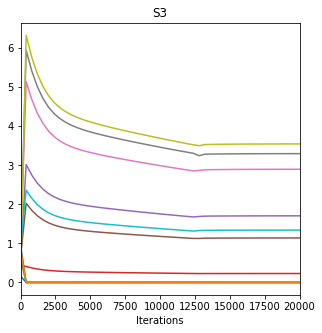

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
# ax = axes.flatten()
count = 0
for scale in [1]:
    for c in [1]:
        tdf = pd.DataFrame(Tfactors[scale][0][c], index=range(len(out[scale][0][c]['costs']))[::step])
        tdf.plot(ax = axes, legend=False)
        
#         ax[count].set_ylim([0, 18000])
#         ax[count].legend(title='constant constrain c')

        axes.set_xlabel("Iterations")
#         ax[count].set_ylabel("STDEV " + str(scale))
        axes.set_title("S3")
        count += 1

plt.savefig("./analysis/0711/S3", bbox_inches="tight", dpi=300, format="pdf")

In [87]:
Afactors = {}
for scale in [1]:
    Afactors[scale] = {}
    for random_seed in range(1):
        Afactors[scale][random_seed] = {}
        for c in [1]:
            Afactors[scale][random_seed][c] = {}
            for j in range(7):
                Afactors[scale][random_seed][c][j] = {}
                for i in range(6):
                    Afactors[scale][random_seed][c][j][i] = []
                
for scale in [1]:
    for random_seed in range(1):
        for c in [1]:
            for i in range(0, 20200, 400):
                for j in range(0, 7):
                    for m in range(2):
                        for n in range(3):
                            Afactors[scale][random_seed][c][j][m*3+n].append(out[scale][random_seed][c]['As'][i][j][m][n])
    

In [88]:
Afactors[1][0][1][1][5]

[0.92929619757621407,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.695390809702488,
 19.69539080

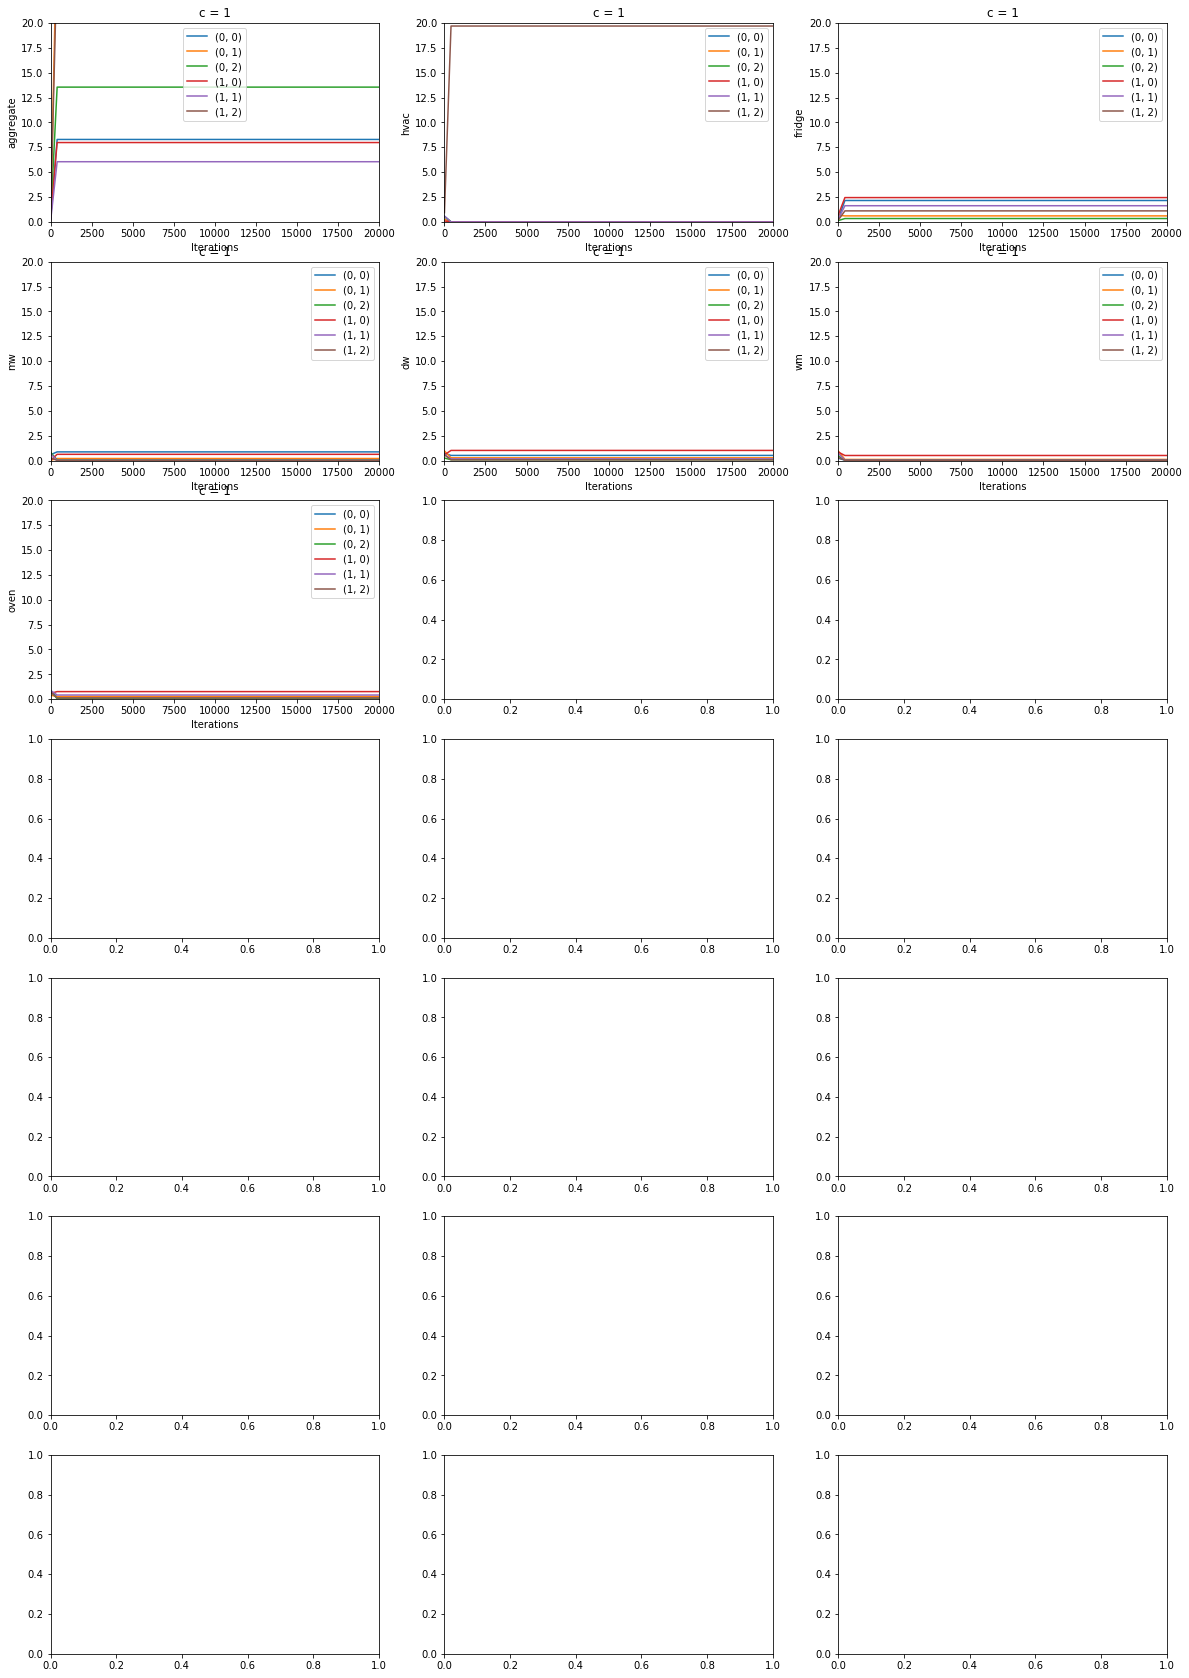

In [89]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20,30))
ax = axes.flatten()
count = 0
# for scale in [1, 5, 10, 20]:
scale=1
for j in range(7):
    for c in [1]:
        adf = pd.DataFrame(Afactors[scale][0][c][j], index=range(len(out[scale][0][c]['costs']))[::step])
        adf.plot(ax = ax[count])
        
        ax[count].legend(["(0, 0)", "(0, 1)", "(0, 2)", "(1, 0)", "(1, 1)", "(1, 2)"])

        ax[count].set_ylim([0, 20])
#             ax[count].legend(title='constant constrain c')

        ax[count].set_xlabel("Iterations")
        ax[count].set_ylabel(APPLIANCES_ORDER[j])
        ax[count].set_title("c = " + str(c))
        count += 1

# adf = pd.DataFrame(Afactors[scale][0][c][j], index=range(len(out[scale][0][c]['costs']))[::step])
# adf.plot()

In [55]:
out[scale][random_seed][c]['Ts'][1600][0]

array([ 0.1       ,  4.46977744])

In [32]:
out[scale][random_seed][c]['Ts'][2000][0][1]
out[scale][random_seed][c]['costs'][::step]

[215.82978397393029,
 40.554750190414822,
 40.497669982807096,
 40.489147576883035,
 40.486054449630998,
 40.484306672590492,
 40.482554249932797,
 40.480796073016613,
 40.479031021110671,
 40.477257955091048,
 40.4754757157977,
 40.473683122435652,
 40.471878970855428,
 40.470062031700621,
 40.468231048416435,
 40.466384735113387,
 40.464521774279788,
 40.462640814336311,
 40.460740467025929,
 40.45881930463166,
 40.45687585701463,
 40.45490860846423,
 40.452915994352011,
 40.450896397580266,
 40.448848144815976,
 40.446769502500501,
 40.444658672624705,
 40.442513788259184,
 40.440332908828516,
 40.43811599658013,
 40.435878115093132]

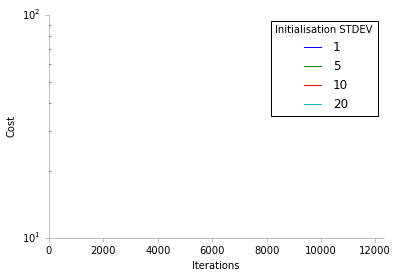

In [18]:
random_seed=0
c=10
step=400
fig, ax  =plt.subplots()
for scale in [1, 5, 10, 20]:
#     for c in [0.1, 1, 10]:
    tdf = pd.DataFrame({scale:out[scale][random_seed][c]['Ts'][0][0][::step]}, index=range(len(out[scale][0][c]['costs']))[::step])
    tdf.plot(logy=True, ax=ax)
    plt.xlim((-10, 12300))
    plt.legend(title='Initialisation STDEV')
    format_axes(ax)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")

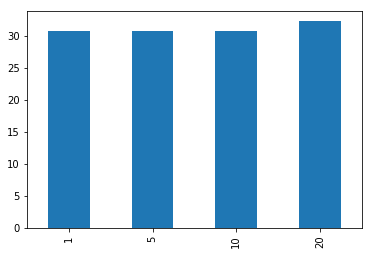

In [79]:
random_seed=0
step=400
fig, ax  =plt.subplots()
c = {}
for scale in [1, 5, 10, 20]:

    c[scale] = out[scale][0]['costs'][12000]
pd.Series(c).plot(kind='bar')